In [1]:
import pnet_loader
import sankey_diag
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
import random
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torch.nn as nn
import os

%load_ext autoreload
%autoreload 2

In [2]:
gene_cn = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_gene_cn.csv').set_index('Unnamed: 0')
gene_cn.rename(columns=dict(zip(gene_cn.columns, [x.split(' ')[0] for x in gene_cn.columns])), inplace=True)

In [3]:
muts = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_mutations.csv')
muts.dropna(subset=['Variant_Classification'], inplace=True)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (5,21,27,28,29,30,31,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
MUTATIONS_DICT = util.MUTATIONS_DICT

In [5]:
grouped_muts = muts[muts['Variant_Classification'].apply(lambda x: MUTATIONS_DICT[x]) != 'Silent'][['Hugo_Symbol',
                                                                                                    'Variant_Classification',
                                                                                                    'Tumor_Sample_Barcode']].groupby(['Tumor_Sample_Barcode',
                                                                                                                                          'Hugo_Symbol']).count()
mut = grouped_muts.unstack(level=-1).fillna(0).droplevel(0, axis=1)

In [6]:
v600e_mut_samples = muts[muts['Protein_Change']=='p.V600E']['Tumor_Sample_Barcode'].values

In [7]:
v600_target = pd.DataFrame(index=mut.index)
v600_target['v600_mut'] = [int(x in v600e_mut_samples) for x in mut.index]

In [8]:
braf_target = pd.DataFrame(mut['BRAF'] > 0).astype(int)
braf_target.rename(columns=dict.fromkeys(['BRAF'],'BRAF_mut'), inplace=True)

In [9]:
df_mut_0 = v600_target[v600_target['v600_mut'] == 0].sample(n=v600_target['v600_mut'].sum(), random_state=42)
df_mut_1 = v600_target[v600_target['v600_mut'] == 1]
downsampled_target = pd.concat([df_mut_0, df_mut_1])

In [10]:
rna = pd.read_csv('/mnt/disks/pancan/CCLE/CCLE_expression_full.csv').set_index('Unnamed: 0')
rna.rename(columns=dict(zip(rna.columns, [x.split(' ')[0] for x in rna.columns])), inplace=True)

In [11]:
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))
canc_genes.remove('BRAF')

In [12]:
genetic_data = {'rna': rna, 'mut': mut}

Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 706 overlapping genes
generated input DataFrame of size (1064, 1412)
Initializing Test Dataset
Found 706 overlapping genes
generated input DataFrame of size (119, 1412)
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 706 overlapping genes
generated input DataFrame of size (1064, 1412)
Initializing Test Dataset
Found 706 overlapping genes
generated input DataFrame of size (119, 1412)
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 706 overlapping genes
generated input DataFrame of size (1064, 1412)
Initializing Test Dataset
Found 706 overlapping genes
generated input DataFrame of size (119, 1412)
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 706 overlapping genes
generated input DataFrame of size (1065, 1412)
Initializing Test Dataset
Found 706 overlapping genes
generated 

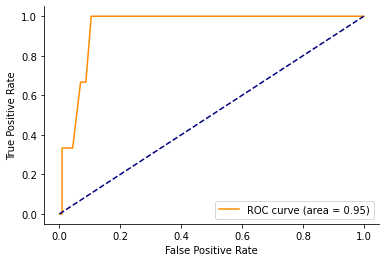

In [13]:
for i in range(10):
    path = '../results/ccle_val_braf_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/ccle/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/ccle/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=v600_target,
                                                                  train_inds=train_inds, test_inds=test_inds, gene_set=canc_genes)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    rfc = RandomForestClassifier(max_depth=None, random_state=0)
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_test)
    preds_prob = rfc.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    auc_prc = util.get_auc_prc(torch.tensor(preds_prob[:,1], dtype=torch.float), y_test)
    f1_score = util.get_f1(torch.tensor(preds, dtype=torch.float), y_test)
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    torch.save(auc_prc, path+'/AUC_PRC.pt')
    torch.save(f1_score, path+'/F1.pt')

In [14]:
class_weights = util.get_class_weights(torch.tensor(v600_target.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/ccle/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/ccle/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, v600_target, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3,
                                                                             weight_decay=1e-3, batch_size=100, epochs=400, early_stopping=True, 
                                                                             loss_weight=class_weights, train_inds=train_inds, test_inds=test_inds,
                                                                             save_path='../results/ccle_val_braf/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/ccle_val_braf/run{}'.format(i))

Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 706 overlapping genes
generated input DataFrame of size (1064, 1412)
Initializing Test Dataset
Found 706 overlapping genes
generated input DataFrame of size (119, 1412)
Found 706 overlapping genes
We are sending to cuda


Exception ignored in: <function _releaseLock at 0x7fd49434e8c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 24823, 24839) exited unexpectedly

In [24]:
datapath='/mnt/disks/pancan/data/'
rna_val, cna_val, tumor_type, mut_val = util.load_tcga_dataset(datapath+'skcm_tcga_pan_can_atlas_2018', load_mut=True)

muts_val = pd.read_csv('/mnt/disks/pancan/data/skcm_tcga_pan_can_atlas_2018/data_mutations.txt', delimiter='\t')
muts_val.dropna(subset=['Variant_Classification'], inplace=True)

grouped_muts_val = muts_val[muts_val['Variant_Classification'].apply(lambda x: MUTATIONS_DICT[x]) != 'Silent'][['Hugo_Symbol',
                                                                                                    'Variant_Classification',
                                                                                                    'Tumor_Sample_Barcode']].groupby(['Tumor_Sample_Barcode',
                                                                                                                                          'Hugo_Symbol']).count()
mut_val = grouped_muts_val.unstack(level=-1).fillna(0).droplevel(0, axis=1)

v600e_mut_samples_val = muts_val[muts_val['HGVSp_Short']=='p.V600E']['Tumor_Sample_Barcode'].values

v600_target_val = pd.DataFrame(index=mut_val.index)
v600_target_val['v600_mut'] = [int(x in v600e_mut_samples_val) for x in mut_val.index]

canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes.txt').values.reshape(-1))
canc_genes = list(set(rna_val.columns).intersection(canc_genes))
canc_genes.remove('BRAF')

genetic_data_val = {'rna': rna_val, 'mut': mut_val}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (4,38,39,43,84) have mixed types.Specify dtype option on import or set low_memory=False.
  
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (4,38,39,43,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
class_weights = util.get_class_weights(torch.tensor(v600_target.values).view(-1))
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run_regulatory(genetic_data, v600_target, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3,
                                                                             weight_decay=1e-3, batch_size=100, epochs=400, early_stopping=True, 
                                                                             loss_weight=class_weights, train_inds=train_inds, test_inds=test_inds,
                                                                             save_path='../results/ccle_val_braf/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)

Task defined: BC 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 1183 overlapping indicies
Initializing Train Dataset
Found 674 overlapping genes
generated input DataFrame of size (1064, 1348)
Initializing Test Dataset
Found 674 overlapping genes
generated input DataFrame of size (119, 1348)
Found 674 overlapping genes
Added regulatory layer
We are sending to cuda
Hit early stopping criteria


In [30]:
inds = pnet_loader.get_indicies(genetic_data = genetic_data_val,
                                target=v600_target_val)
ext_val_dataset = pnet_loader.PnetDataset(genetic_data = genetic_data_val,
                                          target=v600_target_val, indicies=inds, gene_set=canc_genes)

Found 439 overlapping indicies
Found 674 overlapping genes
generated input DataFrame of size (439, 1348)


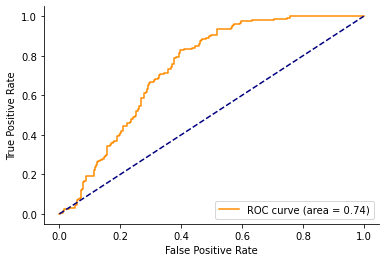

In [31]:
Pnet.evaluate_interpret_save(model, ext_val_dataset, '../results/ccle_val_braf_ext'.format(i))

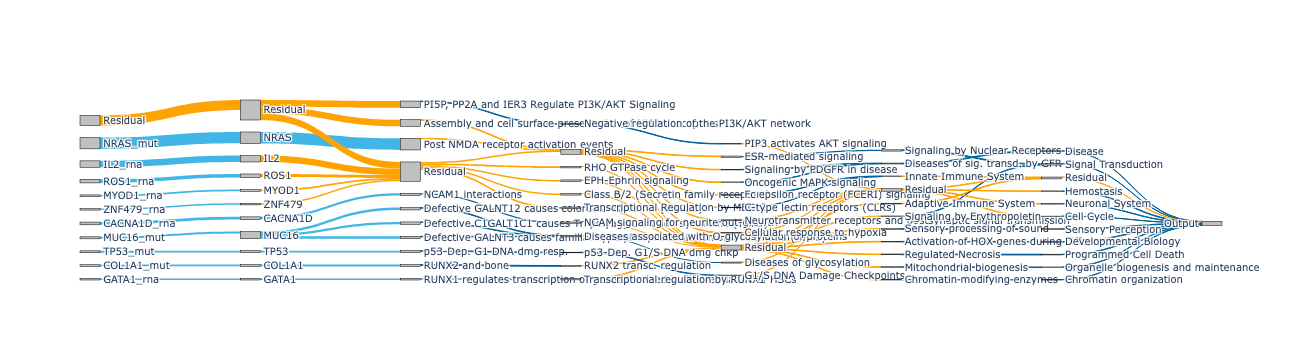

In [32]:
imps_dir = '/mnt/disks/pancan/pnet/results/ccle_val_braf_ext/'
savepath = '/mnt/disks/pancan/pnet/figures/ccle_braf_ext_sankey_diagram.html'
sk = sankey_diag.SankeyDiag(imps_dir, runs=1)
fig = sk.get_sankey_diag(savepath)

In [ ]:
class_weights = util.get_class_weights(torch.tensor(v600_target.values).view(-1))
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/ccle/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/ccle/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run_regulatory(genetic_data, v600_target, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3,
                                                                             weight_decay=1e-3, batch_size=64, epochs=400, early_stopping=True, 
                                                                             loss_weight=class_weights, train_inds=train_inds, test_inds=test_inds,
                                                                             save_path='../results/ccle_val_braf_reg/model',
                                                                             loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/ccle_val_braf_reg/run{}'.format(i))

In [15]:
models = ['ccle_val', 'ccle_val_rf', 'ccle_val_kmt2d', 'ccle_val_kmt2d_rf', 'ccle_val_reg', 'ccle_val_kmt2d_reg', 'ccle_val_braf', 'ccle_val_braf_rf', 'ccle_val_braf_reg']
listl = []
for ds in models:
    for i in range(10):
        auc = torch.load('../results/{}/run{}/AUC.pt'.format(ds, i))
        m = ds.split('_')[-1]
        ds_ = ds.split('_')[-2:]
        if m == 'rf':
            listl.append([auc.item(), ds_[0], 'RF'])
        elif m == 'reg':
            listl.append([auc.item(), ds_[0], 'P-Net-REG'])
        else:
            listl.append([auc.item(), ds_[1], 'P-Net'])

auc_df = pd.DataFrame(listl, columns=['AUC', 'Mutation', 'Model'])
auc_df['Mutation'] = auc_df['Mutation'].apply(lambda x: 'TP53' if x=='val' else x.upper())

In [16]:
auc_df.groupby(['Mutation', 'Model']).mean()

AUC
Mutation Model              
BRAF     P-Net      0.948029
         P-Net-REG  0.961008
         RF         0.878906
KMT2D    P-Net      0.767320
         P-Net-REG  0.765073
         RF         0.732441
TP53     P-Net      0.907241
         P-Net-REG  0.910212
         RF         0.882880

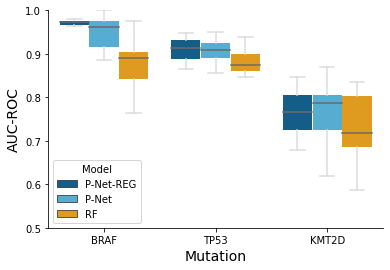

In [17]:
custom_colors = {'P-Net': '#41B6E6', 'RF': '#FFA300', 'P-Net-REG': '#00629B'}
sns.boxplot(data=auc_df, y='AUC', x='Mutation', hue='Model', showfliers=False, palette=custom_colors, hue_order=['P-Net-REG', 'P-Net', 'RF'], order=['BRAF','TP53','KMT2D'],
                      whiskerprops={'color': 'gainsboro'},
                      capprops={'color': 'gainsboro'},
                        boxprops={'edgecolor': 'none'},
                      medianprops={'color': 'dimgrey'})
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('AUC-ROC', size=14)
ax.set_xlabel('Mutation', size=14)
ax.set_ylim((0.5,1))
plt.savefig('../figures/CCLE_mut_prediction_auc.pdf')
plt.show()

In [ ]:
pd.read_csv('/mnt/disks/CCLE')

In [ ]:
imps_dir = '/mnt/disks/pancan/pnet/results/ccle_val_braf/'
savepath = '/mnt/disks/pancan/pnet/figures/ccle_braf_sankey_diagram.html'
sk = sankey_diag.SankeyDiag(imps_dir, runs=10)
fig = sk.get_sankey_diag(savepath)

In [ ]:
imps_dir = '/mnt/disks/pancan/pnet/results/ccle_val_braf/run4/'
savepath = '/mnt/disks/pancan/pnet/figures/ccle_braf_sankey_diagram.html'
sk = sankey_diag.SankeyDiag(imps_dir)
fig = sk.get_sankey_diag(savepath)

In [ ]:
i=9
class_weights = util.get_class_weights(torch.tensor(downsampled_target.values).view(-1))
train_inds = list(pd.read_csv('../data/splits/ccle/train_set_{}.csv'.format(i))['indicies'])
test_inds = list(pd.read_csv('../data/splits/ccle/test_set_{}.csv'.format(i))['indicies'])
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, downsampled_target, seed=0, dropout=0.2, input_dropout=0.5, lr=1e-3,
                                                                         weight_decay=1e-3, batch_size=100, epochs=400, early_stopping=True, 
                                                                         loss_weight=class_weights, train_inds=train_inds, test_inds=test_inds,
                                                                         save_path='../results/ccle_val_braf/model',
                                                                         loss_fn=nn.BCEWithLogitsLoss(reduce=None), gene_set=canc_genes)

In [ ]:
train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, v600_target, canc_genes, test_split=1)

In [ ]:
preds = model.predict(test_dataset.x, additional_data=test_dataset.additional)
preds = pd.DataFrame(preds, index=test_dataset.target.index, columns=['pred']).astype(int)
preds = preds.join(test_dataset.target)
preds['misclass'] = preds['pred']-preds['v600_mut']

In [ ]:
preds[preds['misclass'] != 0]